In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import cv2
import shutil
%matplotlib inline

In [2]:
# Label dictionary
# No tumor = 0
# Tumor = 1

In [3]:
t = cv2.imread('../dataset/yes/Y3.jpg')
t.shape

(519, 456, 3)

In [4]:
# Let's read the image by passing its path
# and resize it to be 128x128
def readImg(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))
    return img

In [5]:
# Grabbing all the datasets
noTumors = os.listdir(path='../dataset/no/')
yesTumors = os.listdir(path='../dataset/yes/')

In [6]:
# Let's create a single list containing all images (test and train)
yesImg = []
noImg = []

for i in noTumors:
    yesImg.append(readImg('../dataset/no/' + i))
for i in yesTumors:
    yesImg.append(readImg('../dataset/yes/' + i))

images = noImg + yesImg

In [7]:
# We're also creating a list with all labels according to 
# each image
noLabels = ['0'] * len(noTumors)
yesLabels = ['1'] * len(yesTumors)

labels = noLabels + yesLabels

In [8]:
# We can now separate the data into training and testing.
# test size will be of 15% and we'll shuffle the data.
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, shuffle=True)

0


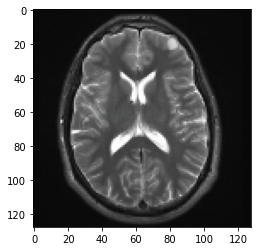

In [9]:
print(y_train[5])
plt.imshow(X_train[5])

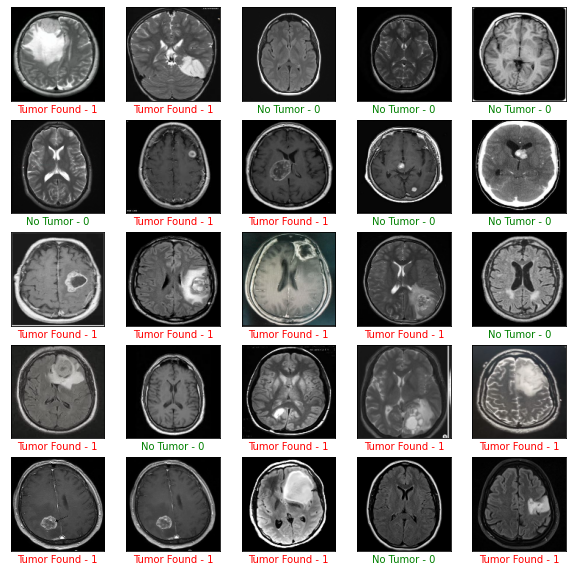

In [10]:
# Let's show all the images and compare to the lables to make sure
# they're all consistent and true to feed to the NN
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    if y_train[i] == '0':
        plt.xlabel('No Tumor - 0', color='g')
    else:
        plt.xlabel('Tumor Found - 1', color='r')
    
plt.show()

In [11]:
# changing from list to numpy array, and changing the type of the 
# labels to be int
trainImages = np.asarray(X_train)
trainLabels = np.asarray(y_train).astype(np.int)
testImages = np.asarray(X_test)
testLabels = np.asarray(y_test).astype(np.int)


In [12]:
# The NN model :)
model = tf.keras.Sequential()

# First layer: 16 filters, kernel size of 3x3, Relu activation
# We'll apply max pooling and a dropout layer.
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=3, activation='relu', input_shape=(128, 128,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(rate=0.45))

# Second layer: 36 filters, kernel size of 3x3, Relu activation
# Followed by a max pooling layer and a dropout layer
model.add(tf.keras.layers.Conv2D(filters=36,kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(rate=0.25))

# Third layer: 56 filters, kernel size of 3x3 and Relu activation
# Max pooling and dropout layers after the third layer
model.add(tf.keras.layers.Conv2D(filters=56, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(rate=0.25))

# Flattening layer
model.add(tf.keras.layers.Flatten())


# Dense layer with 512 units, using Sigmoid as activation
# followed by drouput with rate of 0.15
model.add(tf.keras.layers.Dense(units=512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(rate=0.15))

# Last dense layer with 1 unit and Sigmoid as activation
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [13]:
# Compiling the model using cross entropy as loss function
# and SGD as optimizer
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.SGD(),
             metrics=['acc'])

In [14]:
# Let's train the layers with batch size of 32 and 200 epochs
# should last about 2 - 3 minutes on CPU
history = model.fit(trainImages,
         trainLabels,
         batch_size=32,
         epochs=200,
         validation_data=(testImages, testLabels))

Epoch 1/200
7/7 [==============================] - 1s 128ms/step - loss: 0.7331 - acc: 0.5767 - val_loss: 0.6033 - val_acc: 0.6053
Epoch 2/200
7/7 [==============================] - 1s 99ms/step - loss: 0.6216 - acc: 0.6279 - val_loss: 0.6211 - val_acc: 0.6842
Epoch 3/200
7/7 [==============================] - 1s 104ms/step - loss: 0.5823 - acc: 0.7116 - val_loss: 0.6215 - val_acc: 0.6053
Epoch 4/200
7/7 [==============================] - 1s 98ms/step - loss: 0.6036 - acc: 0.6698 - val_loss: 0.6139 - val_acc: 0.6579
Epoch 5/200
7/7 [==============================] - 1s 104ms/step - loss: 0.5796 - acc: 0.7209 - val_loss: 0.6078 - val_acc: 0.6579
Epoch 6/200
7/7 [==============================] - 1s 97ms/step - loss: 0.5628 - acc: 0.7209 - val_loss: 0.6305 - val_acc: 0.6316
Epoch 7/200
7/7 [==============================] - 1s 98ms/step - loss: 0.5568 - acc: 0.7070 - val_loss: 0.6267 - val_acc: 0.6842
Epoch 8/200
7/7 [==============================] - 1s 98ms/step - loss: 0.5631 - acc: 0

In [15]:
# Let's calculate our accuracy score
score = model.evaluate(testImages, testLabels, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7105262875556946


In [16]:
# Let's predict on out testing set
prediction = model.predict(testImages)

In [17]:
labels =['no', 'yes']

In [18]:
# Let's create the directories to save the images labeled as 1 or true
# to draw the countour later

# Images will be saved at /predicted/raw/
if os.path.isdir('../predicted/raw/'):
    shutil.rmtree('../predicted/raw/')

os.mkdir('../predicted/raw/')

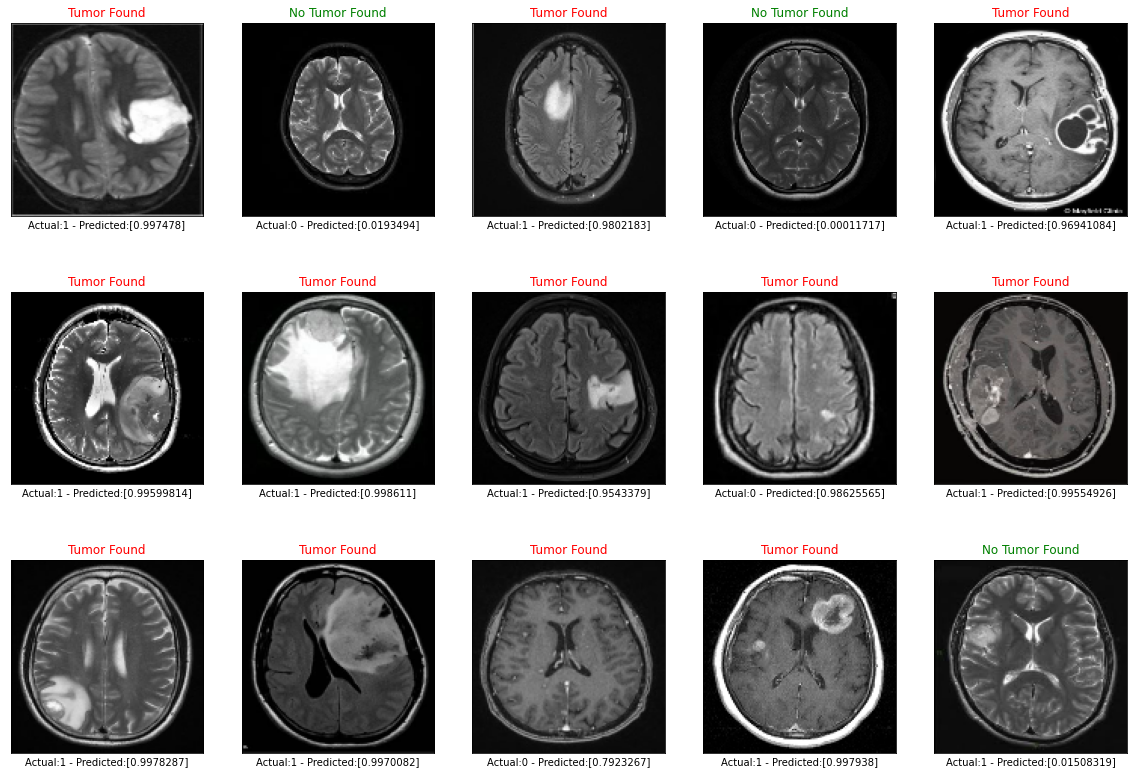

In [19]:
# Plotting final results to evaluate model
y_hat = model.predict(testImages)


figure = plt.figure(figsize=(20, 14))
for i, index in enumerate(np.random.choice(testImages.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(testImages[index]))
    predict_index = int(round(y_hat[index][0]))
    true_index = np.argmax(testLabels[index])

    if predict_index == 1:
        plt.title('Tumor Found', color='r')
        plt.imsave('../predicted/raw/predImg{}.jpg'.format(index), testImages[index])
    else:
        plt.title('No Tumor Found', color='g')
    plt.xlabel('Actual:{} - Predicted:{}'.format(testLabels[index], y_hat[index]))
plt.show()

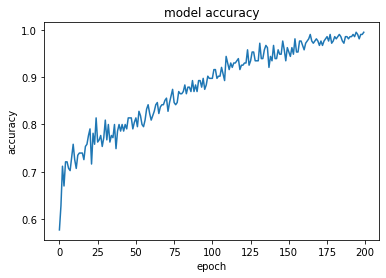

In [20]:
# Plot model accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

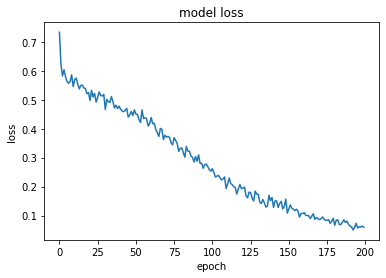

In [21]:
# Plot model loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Created file @ "../predicted/drawn/final0.jpg"
Created file @ "../predicted/drawn/final1.jpg"
Created file @ "../predicted/drawn/final2.jpg"
Created file @ "../predicted/drawn/final3.jpg"
Created file @ "../predicted/drawn/final4.jpg"
Created file @ "../predicted/drawn/final5.jpg"
Created file @ "../predicted/drawn/final6.jpg"
Created file @ "../predicted/drawn/final7.jpg"
Created file @ "../predicted/drawn/final8.jpg"
Created file @ "../predicted/drawn/final9.jpg"
Created file @ "../predicted/drawn/final10.jpg"
Created file @ "../predicted/drawn/final11.jpg"


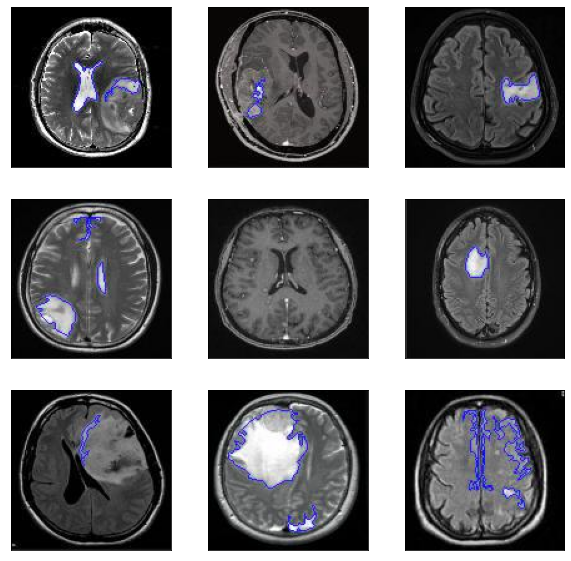

In [22]:
# Run the second notebook
%run ./contouring.ipynb